# Neural style transfer in Keras

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "0, 1"

In [2]:
import numpy as np
from keras.applications import vgg19
from keras.preprocessing.image import load_img, img_to_array

target_image_path = 'creative_commons_elephant.JPG'
style_reference_image_path = 'starrynight.jpg'

width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

Using TensorFlow backend.


In [3]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype(np.uint8)
    return x

In [4]:
# loading the pretrained VGG19 network and applying it to the three images
from keras import backend as K

In [5]:
target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))

input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

Model loaded.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [7]:
# content loss
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# style loss
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# total variation loss
def total_variation_loss(x):
    a = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, 1: , :img_width - 1, :])
    b = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1: , :])
    return K.sum(K.pow(a + b, 1.25))

In [8]:
# defining the final loss 
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.25

loss = K.variable(0.)
# computes content loss
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features, combination_features)

# computes style loss
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
    
# computes total variation loss
loss += total_variation_weight * total_variation_loss(combination_image)

In [9]:
# setting up the gradient-descent process
grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grad_values = None
        
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype(np.float64)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
    
evaluator = Evaluator()      

In [10]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

In [11]:
# style transfer loop
result_dir = '/content/dohai90/workspace/keras/images'
result_prefix = 'my_result'
iterations = 20
fnames = []

x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x, fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = os.path.join(result_dir, result_prefix + '_at_iteration_%d.png' % i)
    fnames.append(fname)
    imsave(fname, img)
    print('Image saved as', fname)
    end_time = time.time()
    print('Iteration % d completed in %d' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 6163477500.0
Image saved as /content/dohai90/workspace/keras/images/my_result_at_iteration_0.png
Iteration  0 completed in 9
Start of iteration 1


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 2062266100.0
Image saved as /content/dohai90/workspace/keras/images/my_result_at_iteration_1.png
Iteration  1 completed in 6
Start of iteration 2
Current loss value: 1223248500.0
Image saved as /content/dohai90/workspace/keras/images/my_result_at_iteration_2.png
Iteration  2 completed in 6
Start of iteration 3
Current loss value: 947191200.0
Image saved as /content/dohai90/workspace/keras/images/my_result_at_iteration_3.png
Iteration  3 completed in 6
Start of iteration 4
Current loss value: 750472900.0
Image saved as /content/dohai90/workspace/keras/images/my_result_at_iteration_4.png
Iteration  4 completed in 6
Start of iteration 5
Current loss value: 650796540.0
Image saved as /content/dohai90/workspace/keras/images/my_result_at_iteration_5.png
Iteration  5 completed in 6
Start of iteration 6
Current loss value: 580644300.0
Image saved as /content/dohai90/workspace/keras/images/my_result_at_iteration_6.png
Iteration  6 completed in 6
Start of iteration 7
Current 

In [14]:
import matplotlib.pyplot as plt
from PIL import Image

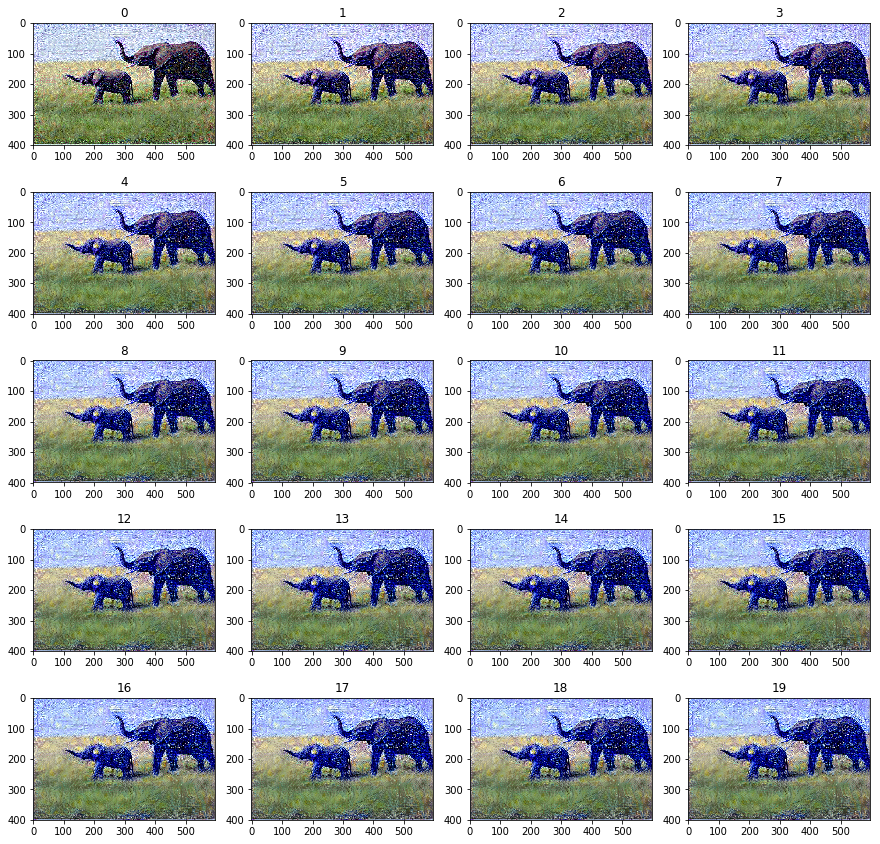

In [27]:
fig = plt.figure(figsize=(15, 15))
n_images = len(fnames)
cols = 4

for i, fname in enumerate(fnames):
    img = Image.open(fname)
    a = fig.add_subplot(np.ceil(n_images/float(cols)), cols, i + 1)
    a.set_title(str(i))
    plt.imshow(img)
    
plt.show()